## **How To Split The Data Effectively.**

### **Table of content:**

1. Why should we split wer data?

2. What Should Be The Splitting Percentage?
3. Split at the early  beginning
4. Consistent Split 
5. Avoid Sampling Bias

In [1]:
import os
import tarfile
import urllib.request

import numpy as np 
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### **1. Why should we split data?**

Splitting data into train and test or splitting it into train, validation, and test is a common step in ML pipeline. 

The train set is used to fit and train the model while the test set is used to evaluate the trained model so as to get a better idea of how good the model is on new data and how it will act in the production environment. 

Therefore the test data need to be similar to what is expected to be seen in the production. 

Another common splitting technique is to split the data into three datasets: train, validation, and test dataset. 

The validation dataset will be used to choose the best hyperparameters.

### **2. What Should Be The Splitting Percentage?**

The percentage of the test data depends on many factors that's why there is no optimal splitting percentage. We must choose a split percentage that takes into account the following considerations :

* **Computational cost in training the model:** If the cost of training the model is high this might affect our ability to evaluate multiple models especially if we will use a validation dataset. 

* **Size of the data:** This is a very important factor if we have a small dataset so probably we will not be able to split the data another good option will be using k-fold cross-validation for evaluation. 
If the size of the data is so big then it will be more than enough to split a small portion of the data and use it as a test dataset. 


### **3. Split At The Early Beginning**

The reason for this is that our brain is an amazing pattern detection system, which means that it is highly prone to **overfitting**.

Therefore when we estimate the generalization error using the test set after training wer model, our estimate will be too optimistic, and we will launch a system into production that will not perform as well as expected. This is called **"data leakage"**.

### **4. Consistent Splitting**

We will be using the California housing prices dataset throughout this notebook.

Kaggle Link : https://www.kaggle.com/datasets/camnugent/california-housing-prices/

In [2]:
housing_df = pd.read_csv('data/housing.csv')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now let's define the splitting function to split the data into training and test set:

In [3]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [4]:
train_set, test_set = split_train_test(housing_df, 0.2)

In [5]:
print('The size of the training data  :', len(train_set))
print('The size of the testing data : ', len(test_set))

The size of the training data  : 16512
The size of the testing data :  4128


This method works,  but it has a major artifact. If we run this code again, it will generate a different test set!! Over time, we (or our ML algorithms) will get to see the whole dataset, which is what we want to avoid.

There are some potential solutions that can be done to avoid this:

* One solution is to save the test set on the first run in a separate file and then load it in the subsequent runs.

* Another option is to set the random number generator's seed (ex :  **np.random.seed(42)**) before calling **np.random.permutation()**, so that it always generates the same shuffled indices.

**However, both of these solutions will break the next time we fetch an updated dataset.** 

A common better, and more reliable solution is to use each instance's identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). 

For example, we could compute a hash of each instance's identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. 

This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

Here is a possible implementation:

In [6]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [7]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, our housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [8]:
# Adding an `index` column.
housing_with_id = housing_df.reset_index()

In [9]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

However, it is important to note that if we use the row index as a unique identifier, we need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. 

If this is not possible, then we can try to use the most stable features to build a unique identifier. 

For example, in the housing data set, the district's latitude and longitude are very good choices since they are guaranteed to be stable for a few million years so we could combine them into an ID like the following:

In [10]:
housing_with_id["id"] = housing_df["longitude"] * 1000 + housing_df["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

**Scikit-Learn** provides a few functions to split datasets into multiple subsets in various ways. 

The simplest function is **train_test_split**, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. 

First, there is a random_state parameter that allows we to set the random generator seed as explained previously, and second, we can pass it through multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if we have a separate dataframe for labels):

In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)

### **5. Avoid Sampling Bias**

So far, we have considered purely random sampling methods for getting and splitting test data. 

This is generally fine if the dataset is large enough (especially relative to the #attributes), but if it is not, we run the risk of introducing a significant sampling bias.

Let's consider a survey company that decided to call 1,000 people to ask them a few questions, they don't just pick 1,000 people randomly in a phone book. 

They try to ensure that these 1,000 people are representative of the whole population. 

For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 females and 487 males. We should try to do the same when splitting our dataset.

This is called **stratified sampling**, in which the population is divided into homogeneous subgroups called **strata**, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

 So in the previous example, if they used purely random sampling, there would be about a 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

We can assume that median income is a very important attribute in predicting median housing prices. Therefore we should  ensure that the test set is representative of the various categories of incomes in the whole dataset.

Since the median income is a continuous numerical attribute, we first need to create an income category attribute. Let's plot a histogram for the median income feature :

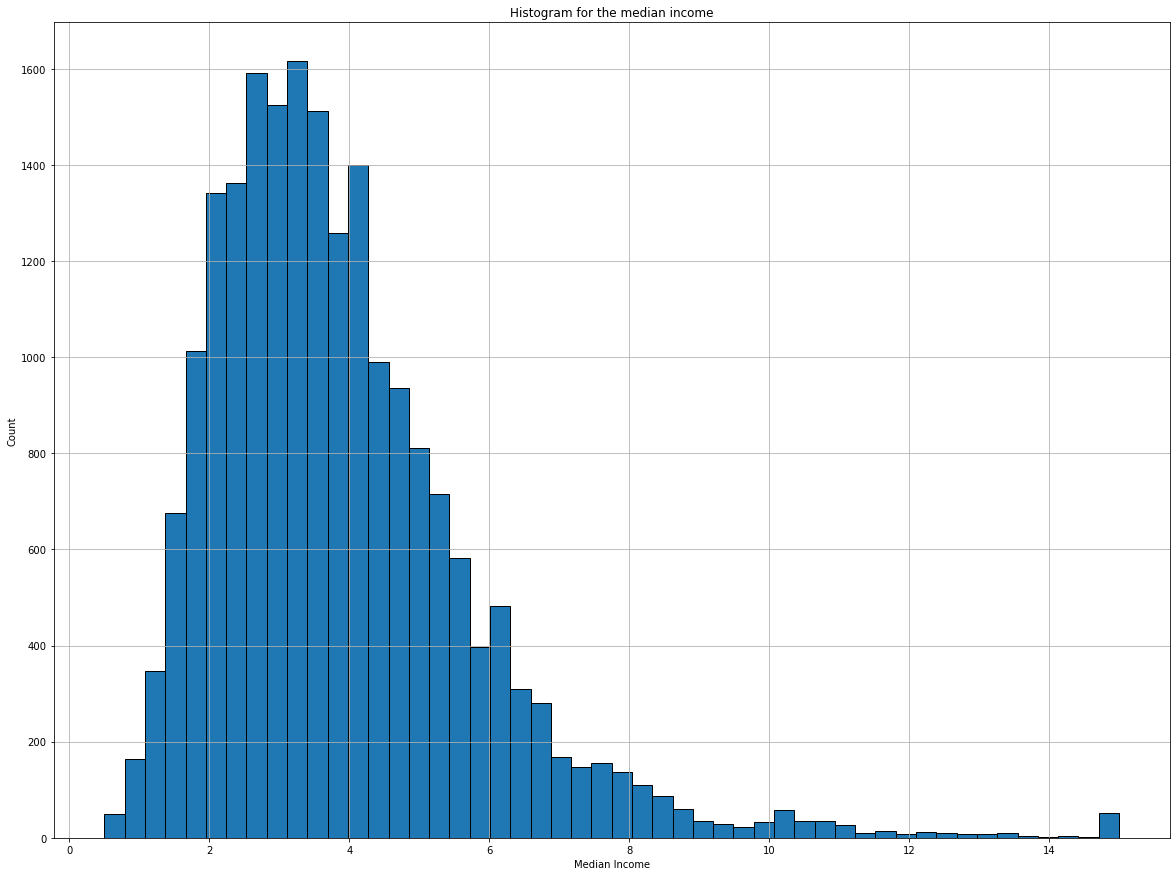

In [12]:
housing_df['median_income'].hist(bins=50, figsize=(20,15), ec='black')

plt.xlabel('Median Income')
plt.ylabel('Count')
plt.title('Histogram for the median income')
plt.show()

We can see that most of the median income values are clustered around 2 to 5 (i.e.,$20,000–$50,000), but some median incomes go far beyond 6 (i.e., $60,000). 

It is important to have a sufficient #instances in the dataset for each stratum, or else the estimate of the stratum's importance may be biased. 

This means that we should not have too many strata, and each stratum should be large enough.

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories) and rounding up using ceil (to have discrete categories), and then keeping only the categories lower than 5 and merging the other categories into category 5:

In [13]:
housing_df["income_cat"] = np.ceil(housing_df["median_income"] / 1.5)
housing_df["income_cat"].where(housing_df["income_cat"] < 5, 5.0, inplace=True)

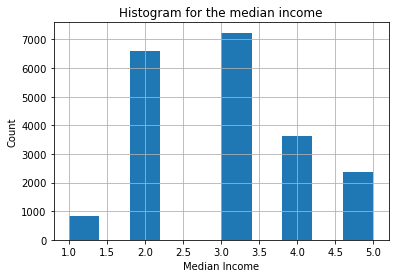

In [14]:
housing_df["income_cat"].hist()

plt.xlabel('Median Income')
plt.ylabel('Count')
plt.title('Histogram for the median income')
plt.show()

Now we are ready to do stratified sampling based on the income category. For this, we will use Scikit-Learn's **StratifiedShuffleSplit** class:

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

Let's see if this worked as expected. we can start by looking at the income category proportions in the stratified test set and compare it with the proportions in the overall dataset:

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

We can also measure the income category proportions in the full dataset as the following :

In [18]:
housing_df["income_cat"].value_counts() / len(housing_df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64